Data Preprocessing

In [2]:
# Get your import statement here
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

#for data preprocessing
from sklearn.decomposition import PCA

#for modeling
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest



In [3]:
# Load your dataset here
from google.colab import files
uploaded = files.upload()
print ('Data read into a pandas dataframe!')

Saving creditcard.csv to creditcard.csv
Data read into a pandas dataframe!


Exploratory Data Analysis

In [4]:
import warnings
warnings.filterwarnings("ignore")

import os
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Lets visualize how many fraud cases we have in this dataset

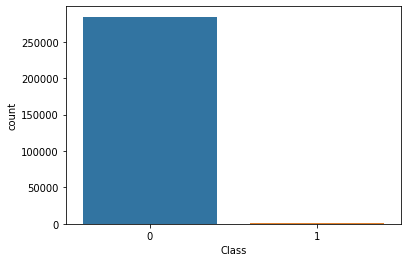

0    284315
1       492
Name: Class, dtype: int64


In [5]:
sns.countplot(df.Class)
plt.show()
print(df.Class.value_counts())

We have 0.17% fraud cases in the dataset which are anomalies.

Only Time and Amount have not been transformed with PCA. Time contains the seconds elapsed between each transaction and the first transaction in the dataset. Lets transofrm this feature into hours to get a better understanding.

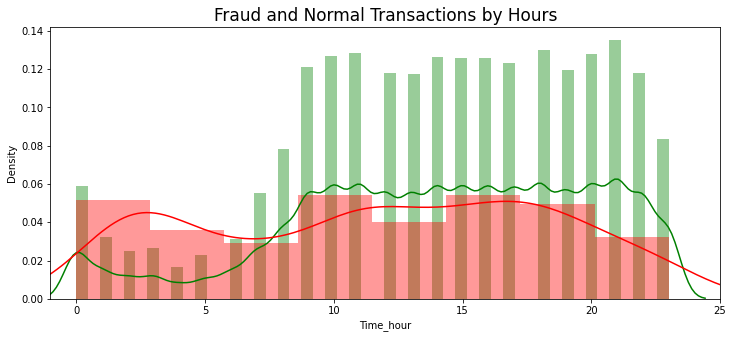

In [6]:
timedelta = pd.to_timedelta(df['Time'], unit='s')
df['Time_hour'] = (timedelta.dt.components.hours).astype(int)

plt.figure(figsize=(12,5))
sns.distplot(df[df['Class'] == 0]["Time_hour"], color='g')
sns.distplot(df[df['Class'] == 1]["Time_hour"], color='r')
plt.title('Fraud and Normal Transactions by Hours', fontsize=17)
plt.xlim([-1,25])
plt.show()

Seems like hour of day have some impact on number or fraud cases. Lets move to transform the remaining features.



Feature Transformation
Lets transform the remaining features using PCA.

In [7]:
cols= df[['Time', 'Amount']]

pca = PCA()
pca.fit(cols)
X_PCA = pca.transform(cols)

df['V29']=X_PCA[:,0]
df['V30']=X_PCA[:,1]

df.drop(['Time','Time_hour', 'Amount'], axis=1, inplace=True)

df.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Class', 'V29', 'V30'],
      dtype='object')

Now lets have a view at distribution of features

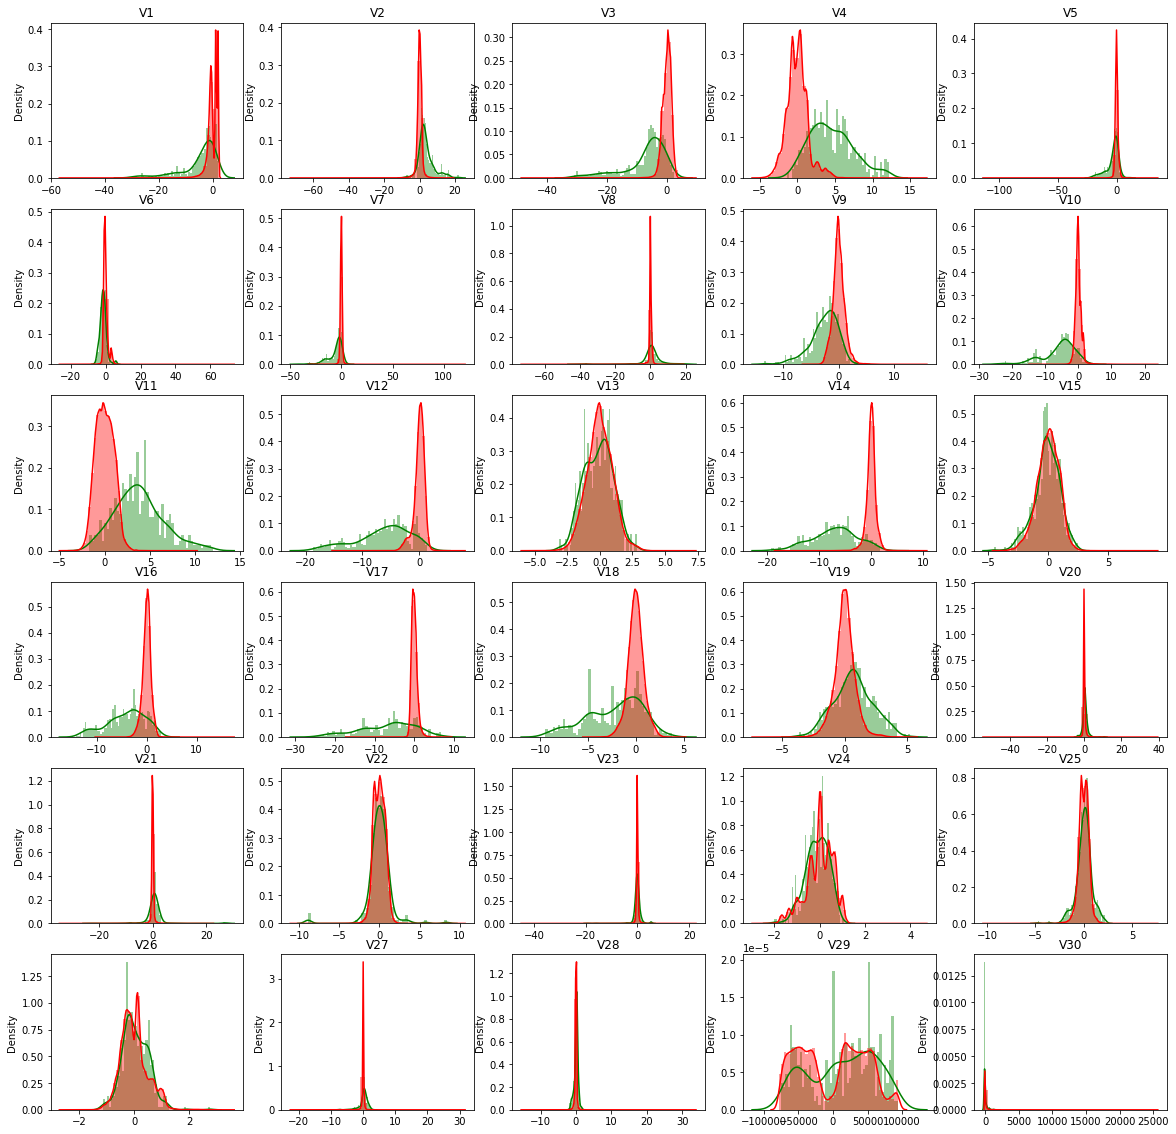

In [8]:
columns = df.drop('Class', axis=1).columns
grid = gridspec.GridSpec(6, 5)

plt.figure(figsize=(20,10*2))

for n, col in enumerate(df[columns]):
    ax = plt.subplot(grid[n])
    sns.distplot(df[df.Class==1][col], bins = 50, color='g')
    sns.distplot(df[df.Class==0][col], bins = 50, color='r') 
    ax.set_ylabel('Density')
    ax.set_title(str(col))
    ax.set_xlabel('')
    
plt.show()


As we can see that data distribution of normal and fraud cases of some features like V18, V20, V25 are overlapping and they seem same. Such features are not good at differentiating between normal and fraud transactions.

Feature Selection using Z-test
Lets move to do some hypothesis testing to find statistically significant features. We will be performing Z-test with valid transactions as our population.

So the case is we have to find if the values of fraud transactions are significantly different from normal transaction or not for all features. The level of significance is 0.01 and its a two tailed test.

Scenario:
Valid transactions as our population
Fraud transactions as sample
Two tailed Z-test
Level of significance 0.01
Corresponding critical value is 2.58
Hypothesis:
H0: There is no difference (insignificant)
H1: There is a difference (significant)
Formula for z-score:
Zscore=(x¯−μ)/S.E

In [9]:
def ztest(feature):
    
    mean = normal[feature].mean()
    std = fraud[feature].std()
    zScore = (fraud[feature].mean() - mean) / (std/np.sqrt(sample_size))
    
    return zScore

In [10]:
columns= df.drop('Class', axis=1).columns
normal= df[df.Class==0]
fraud= df[df.Class==1]
sample_size=len(fraud)
significant_features=[]
critical_value=2.58

for i in columns:
    
    z_vavlue=ztest(i)
    
    if( abs(z_vavlue) >= critical_value):    
        print(i," is statistically significant") #Reject Null hypothesis. i.e. H0
        significant_features.append(i)

V1  is statistically significant
V2  is statistically significant
V3  is statistically significant
V4  is statistically significant
V5  is statistically significant
V6  is statistically significant
V7  is statistically significant
V9  is statistically significant
V10  is statistically significant
V11  is statistically significant
V12  is statistically significant
V14  is statistically significant
V16  is statistically significant
V17  is statistically significant
V18  is statistically significant
V19  is statistically significant
V20  is statistically significant
V21  is statistically significant
V24  is statistically significant
V27  is statistically significant
V28  is statistically significant
V29  is statistically significant
V30  is statistically significant


As we have already seen from distribution plots that distribution of normal and fraud data of V13, V15, V22, V23, V25 and 26 features is almost same, now, its proven through hypothesis testing. We will eliminate these features from our dataset as they don't contribute at all.

Split data into Inliers and Outliers
Inliers are values that are normal.Outliers are values that don't belong to normal data and they are the anomalies.

In [11]:
significant_features.append('Class')
df= df[significant_features]

inliers = df[df.Class==0]
ins = inliers.drop(['Class'], axis=1)

outliers = df[df.Class==1]
outs = outliers.drop(['Class'], axis=1)

ins.shape, outs.shape

((284315, 23), (492, 23))

Modeling
We will be using two unsupervised learning algorithms for anomaly detection.

1. ISOLATION FOREST
Isolation Forest is an unsupervised anomaly detection algorithm that uses the two properties “Few” and “Different” of anomalies to detect their existence. Since anomalies are few and different, they are more susceptible to isolation. This algorithm isolates each point in the data and splits them into outliers or inliers. This split depends on how long it takes to separate the points. If we try to separate a point which is obviously a non-outlier, it’ll have many points in its round, so that it will be really difficult to isolate. On the other hand, if the point is an outlier, it’ll be alone and we’ll find it very easily.

2. Local Outlier Factor
The Local Outlier Factor (LOF) algorithm is an unsupervised anomaly detection method which computes the local density deviation of a given data point with respect to its neighbors. It is a calculation that looks at the neighbors of a certain point to find out its density and compare this to the density of neighbour points later on. In short we can say that the density around an outlier object is significantly different from the density around its neighbors. LOF considers as outliers the samples that have a substantially lower density than their neighbors.

In [1]:
def normal_accuracy(values):
    
    tp=list(values).count(1)
    total=values.shape[0]
    accuracy=np.round(tp/total,4)
    
    return accuracy

def fraud_accuracy(values):
    
    tn=list(values).count(-1)
    total=values.shape[0]
    accuracy=np.round(tn/total,4)
    
    return accuracy

Isolation Forest

We can fill in the missing value from one column to another, which will help us reduce missing values. Expected values:

(6, 20)

(1366, 20)

In [13]:

state= 42

ISF = IsolationForest(random_state=state)
ISF.fit(ins)

normal_isf = ISF.predict(ins)
fraud_isf = ISF.predict(outs)

in_accuracy_isf=normal_accuracy(normal_isf)
out_accuracy_isf=fraud_accuracy(fraud_isf)
print("Accuracy in Detecting Normal Cases:", in_accuracy_isf)
print("Accuracy in Detecting Fraud Cases:", out_accuracy_isf)

Accuracy in Detecting Normal Cases: 0.9581
Accuracy in Detecting Fraud Cases: 0.8598


Local Outlier Factor

In [14]:
LOF = LocalOutlierFactor(novelty=True)
LOF.fit(ins)

normal_lof = LOF.predict(ins)
fraud_lof = LOF.predict(outs)

in_accuracy_lof=normal_accuracy(normal_lof)
out_accuracy_lof=fraud_accuracy(fraud_lof)
print("Accuracy in Detecting Normal Cases:", in_accuracy_lof)
print("Accuracy in Detecting Fraud Cases:", out_accuracy_lof)

Accuracy in Detecting Normal Cases: 0.9875
Accuracy in Detecting Fraud Cases: 0.2358


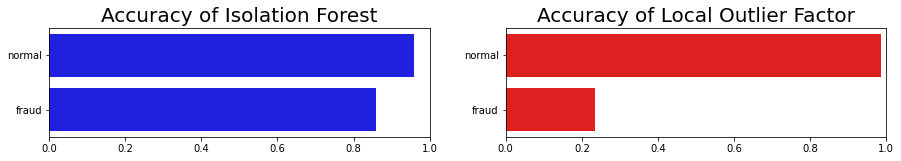

In [15]:
fig, (ax1,ax2)= plt.subplots(1,2, figsize=[15,2])

ax1.set_title("Accuracy of Isolation Forest",fontsize=20)
sns.barplot(x=[in_accuracy_isf,out_accuracy_isf], 
            y=['normal', 'fraud'],
            label="classifiers", 
            color="b", 
            ax=ax1)
ax1.set(xlim=(0,1))

ax2.set_title("Accuracy of Local Outlier Factor",fontsize=20)
sns.barplot(x=[in_accuracy_lof,out_accuracy_lof], 
            y=['normal', 'fraud'], 
            label="classifiers", 
            color="r", 
            ax=ax2)
ax2.set(xlim=(0,1))
plt.show()

CONCLUSION
Both, Isolation Forest and Local Outlier Factor performed same in predicting Normal cases but Isolation Forest performed far better in detecting Fraud cases. So, Isolation Forest is a clear winner here!